<a href="https://colab.research.google.com/github/Sooryakiran/CS6886_SysDL/blob/master/assignment_3/Submission/Step%203/step_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Channel pruning

Import all libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import copy
from IPython.display import HTML, display
from torchsummary import summary

In [0]:
BATCH_SIZE = 32
INITIALIZAION = torch.nn.init.kaiming_uniform_
LEARNING_RATE = 0.01
MOMENTUM = 0.9

LOG_DIR = "drive/My Drive/SysDL/Assg 3/pruning_models/"

### Define basic classes and functions

In [0]:
class NormalizeTransform:
    """
    A torch transform class that normalises the dataset

    """
    
    def __init__(self, mean = 0.5, var = 0.5):
        """
        The class constructor

        @param mean : mean of the output dataset
        @param var  : variance of the output datset

        """

        self.mean = mean
        self.var  = var
    
    def __call__(self, x):
        """
        This function is called when the object is called.

        @param x : input datset
        @returns : normalized dataset

        """

        return (x-self.mean)/(self.var)


def imshow(image):
    """
    A function to print images of size 28x28 from the dataset

    @param image: input torch tensor representing the image

    """

    npimg = image.numpy()
    plt.imshow(np.resize(npimg, (28, 28)), cmap = 'gray')
    plt.show()

def progress(value, max=100):
    """
    Progress bar

    """
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value = value, max = max))

class ConvNet(nn.Module):
    """
    The network is defined as a torch module.

    """

    def __init__(self,\
                 conv_layer_1_filter_size,\
                 conv_layer_2_filter_size,\
                 conv_layer_1_channel_size,\
                 conv_layer_2_channel_size,\
                 layer_3_size):
        
        """
        The class constructor.

        """

        super(ConvNet, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = conv_layer_1_channel_size,  kernel_size = conv_layer_1_filter_size)
        self.conv_2 = nn.Conv2d(in_channels = conv_layer_1_channel_size, out_channels = conv_layer_2_channel_size, kernel_size = conv_layer_2_filter_size)
        
        size = 28
        size = size - conv_layer_1_filter_size + 1
        size = size - conv_layer_2_filter_size + 1
        self.fc_1_input_size = conv_layer_2_channel_size*size*size
        self.fc_1   = nn.Linear(self.fc_1_input_size, layer_3_size)
        self.fc_2   = nn.Linear(layer_3_size, 10)

    def forward(self, x):
        """
        The forward pass of the network.

        Layer 1: Convolution 3x3 16 channels with relu
        Layer 2: Convolution 3x3 16 channels with relu
        Layer 3: Fully connected 100 neurons with relu
        Layer 4: Output fully connected layer 10 neurons without activation 

        @param x : Input tensor of size (BATCH_SIZE, 1, 28, 28)
        @return  : Network output tensor of size (BATCH_SIZE, 10)

        """
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = x.view(-1,  self.fc_1_input_size)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


class initParams:
    """
    An object to initialize the network parameters throgh the method specified

    """

    def __init__(self, method = torch.nn.init.xavier_uniform_):
        """
        The class constructor.

        @param method: the torch.nn.init function to be used to initialize the
                       network parameters

        """

        self.method = method
    
    def __call__(self, layer):
        """
        A function to initialize the network parameters. The weights are initialized
        with given method (default = Xavier uniform) initialization. The biases are 
        initialized with zeros.

        Usage:
            net.apply(init_params)
            where net is an nn.Module or nn.Seqential
        
        @param layer : each layers of the nn.Module/nn.Sequential

        """

        if type(layer) == nn.Linear:
            self.method(layer.weight)
            layer.bias.data.fill_(0.0)

        elif type(layer) == nn.Conv2d:
            self.method(layer.weight)
            layer.bias.data.fill_(0.0)


def accuracy(pred, target):
    """
    A function to calculate accuracy of a prediction.

    @param pred   : Network predictions tensor of size (BATCH_SIZE, num outputs)
    @param target : Target labels of size (BATCh_SIZE)

    Note: @param target is NOT onehot encoded.

    @return       : accuracy of the prediction.

    """

    preds    = torch.argmax(pred, dim = -1).detach().numpy()
    target   = target.detach().numpy()
    corrects = np.mean(np.asarray([preds[i] == target[i] for i in range(preds.shape[0])]))
    return corrects

def test(network, test_loader, criterion, accuracy_fn):
    """
    This function evaluates a model on the test dataset.

    @param network     : Neural network model
    @param test_loader : The dataloader object for the test dataset
    @param criterion   : The loss function
    @param accuracy_fn : The accuracy function

    @return test_loss, test_accuracy 

    """

    loss     = 0.0
    accuracy = 0.0
    batches  = 0

    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs        = network(inputs)

        loss     += criterion(outputs, labels)
        accuracy += accuracy_fn(outputs, labels)
        batches   = i + 1
    
    return (loss/batches).item(), (accuracy/batches).item()

def train_and_evaluate(network, criterion, optimizer, train_dataloader, test_dataloader, train_till = 90, verbose = True):
    """
    A function which trains the given network till the training accuracy reaches
    the specified value, on the given dataset, using the specified loss function
    and using the given optimzer.

    @param network          : Torch nn.Module or nn.Sequential network object
    @param criterion        : The loss function
    @param optimizer        : The optimizer object
    @param train_dataloader : The dataloader object of the training dataset
    @param test_dataloader  : The dataloader object of the test dataset
    @param train_till       : The training accuracy till which the network has 
                              to be trained
    @return t_acc           : Test accuracy on training till training accuracy 
                              becomes the specified value
    @return training_time   : Time required to reach the specified training 
                              accuracy

    """
    done = False

    start_time = time.time()
    while not done:

        running_loss     = 0.0
        running_accuracy = 0.0

        for i, data in enumerate(train_dataloader):
            if not done:
                inputs, labels = data
                optimizer.zero_grad()

                outputs = net(inputs)
                loss    = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss     += loss.item()
                running_accuracy += accuracy(outputs, labels)

                PRINT_EVERY = 256
                if i % PRINT_EVERY == PRINT_EVERY - 1:    
                    if verbose:
                        
                        
                        t_loss, t_acc = test(network, test_dataloader, criterion, accuracy)
                        print('[BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %%\t Test Loss: %f\t Test Accuracy: %f %%' %
                            (i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY, t_loss, t_acc*100))

                    done             = running_accuracy*100/PRINT_EVERY > train_till
                    running_accuracy = 0.0
                    running_loss     = 0.0

    return t_acc, time.time() - start_time

def log(model_id, t_acc, log_dir = LOG_DIR):
    """
    A logging function

    """

    fp = open(log_dir + "logs.log", 'a')
    logs = "[MODEL ID: " + str(model_id) + "] " + "Test Accuracy: " + str(t_acc) +"\n"
    fp.write(logs)
    fp.close()

def train(network, criterion, optimizer, epochs, train_dataloader):
    """
    A handy function for training

    @param network              : The network nn.Module model for training
    @param criterion            : The loss function
    @param optimizer            : The optimizer
    @param epochs               : Number of epochs to train
    @param train_dataloader     : The train dataloader
    @return trained network

    """

    for epoch in range(epochs):
        total = 60000
        print("Epoch : %d" %(epoch + 1))
        out   = display(progress(0, 60000), display_id=True)

        running_loss     = 0.0
        running_accuracy = 0.0

        
        
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = network(inputs)
            loss    = criterion(outputs, labels)

            

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_accuracy += accuracy(outputs, labels)
            PRINT_EVERY = 256

            if i % PRINT_EVERY == PRINT_EVERY - 1:
                batch_size       = labels.numpy().shape[0]
                running_accuracy = 0.0
                running_loss     = 0.0
                out.update(progress(i*batch_size, 60000))
        out.update(progress(1, 1))
        _, new_acc = test(network, test_dataloader, criterion, accuracy)
    return network


### Get the datasets and setup the dataloaders

In [0]:
transform = transforms.Compose([transforms.ToTensor(), NormalizeTransform()])

train_dataset = torchvision.datasets.FashionMNIST(train = True,
                                  root = '.',
                                  download = True,
                                  transform = transform)

test_dataset = torchvision.datasets.FashionMNIST(train = False,
                                  root = '.',
                                  download = True, 
                                  transform = transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Train the base model

In [0]:
torch.manual_seed(0)
net         = ConvNet(3, 3, 8, 8, 100)
init_params = initParams(method = INITIALIZAION)
net.apply(init_params)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM)

test_acc, time_ = train_and_evaluate(network = net,\
                                    criterion=criterion,\
                                    optimizer=optimizer,\
                                    train_dataloader = train_dataloader,\
                                    test_dataloader = test_dataloader,\
                                    train_till=90)

[BATCH:   256]	 Loss: 0.679	 Accuracy: 75.317 %	 Test Loss: 0.514095	 Test Accuracy: 81.379792 %
[BATCH:   512]	 Loss: 0.455	 Accuracy: 83.496 %	 Test Loss: 0.462741	 Test Accuracy: 83.316693 %
[BATCH:   768]	 Loss: 0.415	 Accuracy: 84.937 %	 Test Loss: 0.411156	 Test Accuracy: 85.732827 %
[BATCH:  1024]	 Loss: 0.369	 Accuracy: 86.560 %	 Test Loss: 0.385225	 Test Accuracy: 85.942492 %
[BATCH:  1280]	 Loss: 0.341	 Accuracy: 87.903 %	 Test Loss: 0.341637	 Test Accuracy: 87.759585 %
[BATCH:  1536]	 Loss: 0.343	 Accuracy: 87.854 %	 Test Loss: 0.365248	 Test Accuracy: 86.861022 %
[BATCH:  1792]	 Loss: 0.329	 Accuracy: 88.232 %	 Test Loss: 0.360093	 Test Accuracy: 87.030751 %
[BATCH:   256]	 Loss: 0.290	 Accuracy: 89.075 %	 Test Loss: 0.328481	 Test Accuracy: 88.029153 %
[BATCH:   512]	 Loss: 0.289	 Accuracy: 89.771 %	 Test Loss: 0.362681	 Test Accuracy: 87.460064 %
[BATCH:   768]	 Loss: 0.274	 Accuracy: 89.453 %	 Test Loss: 0.329850	 Test Accuracy: 88.188898 %
[BATCH:  1024]	 Loss: 0.282	 A

### Save the model

In [0]:
torch.save(net, "base_model.pth")
!cp base_model.pth drive/My\ Drive/SysDL/Assg\ 3/pruning_models/
base_model_path = LOG_DIR + "base_model.pth"
log("base_model", test_acc)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Inspect weights and bias

In [0]:
model = ConvNet(3, 3, 8, 8, 100)
model = torch.load(base_model_path)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2            [-1, 8, 24, 24]             584
            Linear-3                  [-1, 100]         460,900
            Linear-4                   [-1, 10]           1,010
Total params: 462,574
Trainable params: 462,574
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 1.76
Estimated Total Size (MB): 1.84
----------------------------------------------------------------


### Define basic functions for channel pruning

In [0]:
def is_weight_conv(param):
    """
    Checks whether a weight parameter belongs to Convolutional layer or not.

    """
    return len(list(param.data.size())) == 4

def is_weight_dense(param):
    """
    Checks whether a weight parameter belongs to Dense layer or not.

    """
    return len(list(param.data.size())) == 2

def uniformize(x):
    """
    Normalizes any numpy array between 0 and 1.

    """
    return (x-np.min(x))/(np.max(x)-np.min(x))

def prune_conv_channel(model, out_model, channel, layer_name, next_layer_name):
    """
    Prunes the given channel from the convolutional layer.
    
    @param model           : (nn.Module) Base model from which has to be pruned.
    @param out_model       : (nn.Module) New model with architecture same as the 
                             pruned model.

    NOTE: Models will be passed by reference.

    @param channel         : The channel to be pruned.
    @param layer_name      : Layer name of the layer which is to be pruned.
    @param next_layer_name : Layer name of the layer succeeding the layer to be 
                             pruned.

    @return new model      : New model with parameters copied.

    Implimentation details
    ======================

    Step 1. Remove channel from the weights of current layer.
    Step 2. Remove channel from the bias of the current layer.
    Step 3. If next layer is convolutional,
                Remove the input channel from the weights.
            If next layer is fully connected,
                Remove the segment from the weights corresponding to the removed
                inputs.

    """

    num_channels     = None
    new_model_params = out_model.state_dict()
    
    for name, param in model.named_parameters():
        new_model_params[name] = param.data

        if layer_name in name:
            
            if "weight" in name:
                """
                Remove weight in the given channel.

                """

                other_channels = []

                if channel:
                    other_channels.append(param.data[:channel,:,:,:])
                if param.data.size()[0] > channel + 1:
                    other_channels.append(param.data[channel+1:,:,:,:])

                num_channels           = param.data.size()[0]  
                new_model_params[name] = torch.cat(other_channels, dim = 0)
                
            if "bias" in name:
                """
                Remove bias in the given channel.

                """

                other_channels = []

                if channel:
                    other_channels.append(param.data[:channel])
                if param.data.size()[0] > channel + 1:
                    other_channels.append(param.data[channel+1:])
                    
                new_model_params[name] = torch.cat(other_channels, dim = 0)

    for name, param in model.named_parameters():
        if next_layer_name in name:
            """
            Check if the layer is conv or dense.

            """

            if is_weight_conv(param) and "weight" in name:
                """
                Remove input channel in weights.

                """

                other_channels = []

                if channel:
                    other_channels.append(param.data[:,:channel,:,:])
                if param.data.size()[1] > channel + 1:
                    other_channels.append(param.data[:,channel+1:,:,:])
                    
                new_model_params[name] = torch.cat(other_channels, dim = 1)

            elif "weight" in name:
                """
                Remove input segment in weights.

                """

                segment_length = int(param.data.size()[-1]/num_channels)
                other_channels = []

                if channel:
                    other_channels.append(param.data[:,:channel*segment_length])
                if param.data.size()[1] > channel + 1:
                    other_channels.append(param.data[:,(channel+1)*segment_length:])

                new_model_params[name] = torch.cat(other_channels, dim = 1)

    out_model.load_state_dict(new_model_params)
    return out_model




def prune_fc_neurons(model, out_model, neuron, layer_name, next_layer_name):
    """
    Prunes the given neuron from the convolutional layer.
    
    @param model           : (nn.Module) Base model from which has to be pruned.
    @param out_model       : (nn.Model) New model with architecture same as the 
                             pruned model.

    NOTE: Models will be passed by reference.

    @param neuron          : The neuron to be pruned.
    @param layer_name      : Layer name of the layer which is to be pruned.
    @param next_layer_name : Layer name of the layer succeeding the layer to be 
                             pruned.

    @return new model      : New model with parameters copied.

    Implimentation details
    ======================

    Step 1. Remove neuron from the weights of current layer.
    Step 2. Remove neuron from the bias of the current layer.
    Step 3. Remove the segment from the weights corresponding to the removed
            inputs.

    """

    num_neurons      = None
    new_model_params = out_model.state_dict()


    for name, param in model.named_parameters():
        new_model_params[name] = param.data

        if layer_name in name:
            if "weight" in name:
                """
                Remove weight in the given neuron.

                """

                other_neurons = []

                if neuron:
                    other_neurons.append(param.data[:neuron,:])
                if param.data.size()[0] > neuron + 1:
                    other_neurons.append(param.data[neuron+1:,:])

                num_neurons            = param.data.size()[0]  
                
                new_model_params[name] = torch.cat(other_neurons, dim = 0)
                
            if "bias" in name:
                """
                Remove bias in the given neuron.

                """

                other_neurons = []

                if neuron:
                    other_neurons.append(param.data[:neuron])
                if param.data.size()[0] > neuron + 1:
                    other_neurons.append(param.data[neuron+1:])
                    
                new_model_params[name] = torch.cat(other_neurons, dim = 0)

    for name, param in model.named_parameters():
        if next_layer_name in name:
            if "weight" in name:
                """
                Remove input segment in weights.

                """

                other_neurons = []
                if neuron:
                    other_neurons.append(param.data[:,:neuron])
                if param.data.size()[1] > neuron + 1:
                    other_neurons.append(param.data[:,(neuron+1):])
                
                new_model_params[name] = torch.cat(other_neurons, dim = 1)

    out_model.load_state_dict(new_model_params)
    return out_model

### Test pruning

In [0]:
new_model  = ConvNet(3, 3, 7, 8, 100)
new_model2 = ConvNet(3, 3, 8, 8, 99)

prune_conv_channel(model = model, out_model = new_model, channel = 6, layer_name = "conv_1", next_layer_name = "conv_2")
prune_fc_neurons(model   = model, out_model = new_model2, neuron = 99, layer_name = "fc_1", next_layer_name = "fc_2")

_, acc  = test(new_model, test_dataloader, criterion, accuracy)
_, acc2 = test(new_model2, test_dataloader, criterion, accuracy)

print("New model accuracy: %0.2f %%" %(acc*100))
print("New model 2 accuracy: %0.2f %%" %(acc2*100))


New model accuracy: 87.48 %
New model 2 accuracy: 88.96 %


### Proposed heuristic

Remove channels and neurons than influenze the output minimum. This can be founded by approximated the average of squared weights.

In [0]:
def predict_drop(network, layer_name):
    """
    Predict the accuracy drop score.
    
    @param network    : The nn.Module model.
    @param layer_name : The layer whose weights are about to be pruned.

    @return pred      : NEGATIVE of the predicted drop.
                        argmax(pred) gives the neuron/channel to be pruned.

    """

    influenzes = []
    for name, param in network.named_parameters():
        if layer_name in name:
            vals         = param.data
            squared_vals = vals**2
            if is_weight_conv(param):
                """
                Conv weights

                """
                influenzes.append(torch.mean(squared_vals,\
                                             dim = [1, 2, 3]))
            elif is_weight_dense(param):
                """
                FC weights.

                """
                influenzes.append(torch.mean(squared_vals,\
                                             dim = [1]))
            else:
                """
                Biases
                """
                influenzes.append(squared_vals)

    pred = uniformize(-influenzes[0].numpy() - influenzes[1].numpy())
    return pred


Compare prediction vs real simulation

In [0]:
pred = predict_drop(network = model, layer_name = "conv_1")

In [0]:
real = []
for i in range(8):
    print("Step", i, "of", 8)
    new_model = ConvNet(3, 3, 7, 8, 100)
    prune_conv_channel(model           = model,\
                       out_model       = new_model,\
                       channel         = i,\
                       layer_name      = "conv_1",\
                       next_layer_name = "conv_2")
    
    _, acc = test(new_model,\
                  test_dataloader,\
                  criterion,\
                  accuracy)
    
    real.append(acc)

Step 0 of 8
Step 1 of 8
Step 2 of 8
Step 3 of 8
Step 4 of 8
Step 5 of 8
Step 6 of 8
Step 7 of 8


In [0]:
real = uniformize(np.asarray(real))

### Plot the comparison

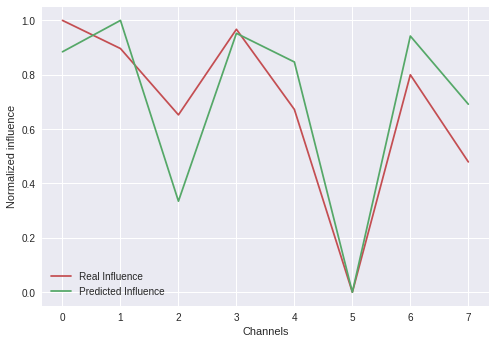

In [0]:
mpl.style.use('seaborn')
fig, ax  = plt.subplots()
channels = np.arange(8)

ax.plot(channels, real,     'C2', label = "Real Influence")
ax.plot(channels, pred[:8], 'C1', label = "Predicted Influence")

plt.ylabel("Normalized influence")
plt.xlabel("Channels")

plt.legend()

### Define important functions

In [0]:
def get_pruning_triplet(network,\
                        layer_name,\
                        architecture,\
                        train_dataloader,\
                        test_dataloader,\
                        criterion,\
                        accuracy,\
                        input_size = (1, 28, 28),\
                        verbose = False):
    
    """
    Prunes a network in the given way and tests its performance.
        Step 1 : The test accuracy of the given network is calculated before
                 pruning.
        Step 2 : A new network is created by pruning the given model.
        Step 3 : Test accuracy of this network is found out.
        Step 4 : The new pruned network is trained for 5 epochs.
        Step 5 : The test accuracy of the new network is found out.

    @param network          : The base model nn.Module.
    @param layer_name       : The name of the layer which has to be pruned.
    @param architecture     : A python dict depicting the network architecture. 
                              A sample format is given below:

                            {
                                "name"   : ["type : conv/fc", arg1, arg2]
                                "name_2" : ["conv", <kernel size>, <filters>]
                                "name_3" : ["fc",   <no of neurons>]
                                "conv_1" : ["conv", 3, 8],
                                "conv_2" : ["conv", 3, 8],
                                "fc_1"   : ["fc",   100],
                                "fc_2"   : ["fc",   10]
                            }
                            
    @param train_dataloader : The train dataloader object.
    @param test_dataloader  : The test dataloader object.
    @param criterion        : The loss function.
    @param accuracy         : The function to calculate accuracy.
    @param input size       : Size of the input images.
    @param verbose          : Prints more logs if set to true.

    @return                 : Triplet-> Accuracy before pruning
                                        Accuracy after pruning
                                        Accuracy after training
                              New model, pruned and trained                         

    """

    def as_int(arg_a, arg_b):
        if arg_a == arg_b:
            return 1
        else:
            return 0

    def next_layer_name():
        return list(architecture)[list(architecture).index(layer_name) + 1]

    _, acc_before_pruning = test(network, test_dataloader, criterion, accuracy)
    predicted_drops       = predict_drop(network = network, layer_name =layer_name)
    arg_to_be_droped      = np.argmax(predicted_drops)

    print("Predictions")
    print(predicted_drops)
    
    print("Dropping channel/neuron %d from %s..." %(arg_to_be_droped, layer_name))
    current_layer_type = architecture[layer_name][0]
    new_model          = ConvNet(architecture["conv_1"][1],\
                                 architecture["conv_2"][1],\
                                 architecture["conv_1"][2] - as_int(layer_name, "conv_1"),\
                                 architecture["conv_2"][2] - as_int(layer_name, "conv_2"),\
                                 architecture["fc_1"][1]   - as_int(layer_name, "fc1"))
    
    if current_layer_type == "conv":
        prune_conv_channel(model           = network,\
                           out_model       = new_model,\
                           channel         = arg_to_be_droped,\
                           layer_name      = layer_name,\
                           next_layer_name = next_layer_name())

    if verbose:
        print("New model")
        summary(new_model, input_size)


    _, acc_after_pruning = test(new_model, test_dataloader, criterion, accuracy)
    
    print("Training new model... This may take a while...")
    optimizer  = optim.SGD(new_model.parameters(), lr = 1e-3, momentum = MOMENTUM)
    new_model  = train(new_model, criterion, optimizer, 5, train_dataloader) 
    _, new_acc = test(new_model, test_dataloader, criterion, accuracy)
    
    print("\nAccuracy Triplet\n" + "="*20 + "\nAccuracy before pruning:\t%0.3f %%" %(acc_before_pruning*100))
    print("Acuracy after pruning:\t\t%0.3f %%"  %(acc_after_pruning*100))
    print("Acuracy after training:\t\t%0.3f %%" %(new_acc*100))

    return acc_before_pruning,\
           acc_after_pruning,\
           new_acc,\
           new_model

### Prune layer 1 once and check

In [0]:
architecture = {"conv_1" : ["conv", 3, 8],
                "conv_2" : ["conv", 3, 8],
                "fc_1"   : ["fc", 100],
                "fc_2"   : ["fc", 10]}

optimizer = optim.SGD(net.parameters(), lr = 1e-3, momentum = MOMENTUM)
get_pruning_triplet(network          = model,\
                    layer_name       = "conv_1",\
                    architecture     = architecture,\
                    train_dataloader = train_dataloader,\
                    test_dataloader  = test_dataloader,\
                    criterion        = criterion,\
                    accuracy         = accuracy)

Predictions
[0.8845845  1.         0.33493328 0.9525502  0.8470237  0.
 0.9424738  0.69176316]
Dropping channel/neuron 1 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	89.018 %
Acuracy after pruning:		88.159 %
Acuracy after training:		90.485 %


(0.8901757188498403, 0.8815894568690096, 0.9048522364217252, ConvNet(
   (conv_1): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
   (conv_2): Conv2d(7, 8, kernel_size=(3, 3), stride=(1, 1))
   (fc_1): Linear(in_features=4608, out_features=100, bias=True)
   (fc_2): Linear(in_features=100, out_features=10, bias=True)
 ))

### Autoprune a layer

Setup MLflow

In [0]:
!pip install mlflow

In [0]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

mlflow.set_tracking_uri("file:///content/drive/My Drive/SysDL/Assg 3/pruning_mlflow")
print("MLflow is now set to log in", mlflow.get_tracking_uri())

MLflow is now set to log in file:///content/drive/My Drive/SysDL/Assg 3/pruning_mlflow


In [0]:
def auto_prune(network,\
              layer_name,\
              architecture,\
              train_dataloader,\
              test_dataloader,\
              criterion,\
              accuracy,\
              input_size = (1, 28, 28),\
              verbose = False,
              max_accuracy_drop = 1):
    
    current_model             = copy.deepcopy(network)
    current_architecture      = architecture
    incremental_accuracy_drop = 0
    possible                  = True

    while((incremental_accuracy_drop < max_accuracy_drop) and possible):

        acc_1, acc_2, acc_3, next_model = get_pruning_triplet(network          = current_model,\
                                                              layer_name       = layer_name,\
                                                              architecture     = current_architecture,\
                                                              train_dataloader = train_dataloader,\
                                                              test_dataloader  = test_dataloader,\
                                                              criterion        = criterion,\
                                                              accuracy         = accuracy)

        incremental_accuracy_drop = (acc_1 - acc_3)*100
        modified_layer = current_architecture[layer_name]
        modified_layer[-1] -= 1
        possible = modified_layer[-1]>1
        current_architecture[layer_name] = modified_layer
        current_model = copy.deepcopy(next_model)

        with mlflow.start_run():
            log_param("Layer", layer_name)
            log_param("New architecture", modified_layer[-1])
            log_param("Channels/Neurons", current_architecture)
            log_metric("Accuracy before pruning", acc_1)
            log_metric("Accuracy after pruning", acc_2)
            log_metric("Accuracy after training", acc_3)
            log_metric("Accuracy drop", incremental_accuracy_drop)

    return current_model


# Make sure to delete existing MLflow logs

In [0]:
new_model = auto_prune(network          = model,\
                       layer_name       = "conv_1",\
                       architecture     = architecture,\
                       train_dataloader = train_dataloader,\
                       test_dataloader  = test_dataloader,\
                       criterion        = criterion,\
                       accuracy         = accuracy)

Predictions
[0.8845845  1.         0.33493328 0.9525502  0.8470237  0.
 0.9424738  0.69176316]
Dropping channel/neuron 1 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	89.018 %
Acuracy after pruning:		88.159 %
Acuracy after training:		90.625 %
Predictions
[0.978964   0.35309774 0.98795044 1.         0.         0.9940442
 0.676462  ]
Dropping channel/neuron 3 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	90.625 %
Acuracy after pruning:		86.891 %
Acuracy after training:		90.845 %
Predictions
[1.         0.33222827 0.9722766  0.         0.9651336  0.5676467 ]
Dropping channel/neuron 0 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	90.845 %
Acuracy after pruning:		89.337 %
Acuracy after training:		90.745 %
Predictions
[0.29644275 0.928216   0.         1.         0.48440984]
Dropping channel/neuron 3 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	90.745 %
Acuracy after pruning:		84.085 %
Acuracy after training:		90.365 %
Predictions
[0.60103714 1.         0.         0.51503366]
Dropping channel/neuron 1 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	90.365 %
Acuracy after pruning:		83.636 %
Acuracy after training:		89.667 %
Predictions
[1.        0.0503584 0.       ]
Dropping channel/neuron 0 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	89.667 %
Acuracy after pruning:		79.573 %
Acuracy after training:		89.537 %
Predictions
[1. 0.]
Dropping channel/neuron 0 from conv_1...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	89.537 %
Acuracy after pruning:		29.503 %
Acuracy after training:		88.099 %


### Autopurune layer 2

In [0]:
new_model2 = auto_prune(network          = new_model,\
                        layer_name       = "conv_2",\
                        architecture     = architecture,\
                        train_dataloader = train_dataloader,\
                        test_dataloader  = test_dataloader,\
                        criterion        = criterion,\
                        accuracy         = accuracy)

Predictions
[0.86495113 0.77056813 1.         0.96754056 0.49902487 0.97328407
 0.         0.42476243]
Dropping channel/neuron 2 from conv_2...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	88.099 %
Acuracy after pruning:		88.099 %
Acuracy after training:		88.089 %
Predictions
[0.89554876 0.7802166  0.99188286 0.70504946 1.         0.
 0.47078836]
Dropping channel/neuron 4 from conv_2...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	88.089 %
Acuracy after pruning:		73.373 %
Acuracy after training:		88.219 %
Predictions
[0.914983  0.7949469 1.        0.8109321 0.        0.5366708]
Dropping channel/neuron 2 from conv_2...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	88.219 %
Acuracy after pruning:		84.615 %
Acuracy after training:		88.149 %
Predictions
[1.         0.863      0.93521255 0.         0.6119275 ]
Dropping channel/neuron 0 from conv_2...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	88.149 %
Acuracy after pruning:		75.879 %
Acuracy after training:		87.909 %
Predictions
[0.905739   1.         0.         0.71371365]
Dropping channel/neuron 1 from conv_2...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	87.909 %
Acuracy after pruning:		87.839 %
Acuracy after training:		88.269 %
Predictions
[1.         0.         0.80197793]
Dropping channel/neuron 0 from conv_2...
Training new model... This may take a while...
Epoch : 1


Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	88.269 %
Acuracy after pruning:		64.786 %
Acuracy after training:		86.452 %


### Autoprune the FC layer

In [0]:
new_model3 = auto_prune(network          = new_model2,\
                        layer_name       = "fc_1",\
                        architecture     = architecture,\
                        train_dataloader = train_dataloader,\
                        test_dataloader  = test_dataloader,\
                        criterion        = criterion,\
                        accuracy         = accuracy)

Predictions
[0.9288651  0.876256   0.9746551  0.95825183 0.9572302  0.87499213
 0.9853959  0.91840565 0.9451444  0.9519546  0.7568931  0.9365179
 0.9610597  0.9964489  0.87893313 0.7627487  0.9990197  0.9562589
 0.9849927  0.16589418 0.9744263  0.88899624 0.73713666 0.9612308
 0.8761925  0.4867507  0.886779   0.9560824  0.90476173 0.96966726
 0.7572231  0.790627   0.98978317 0.8098455  0.8855743  0.8827665
 0.67243934 0.9703534  0.9361117  0.9149846  0.929796   0.97038937
 0.998961   0.8903464  0.86272424 0.40434015 0.85240483 0.91075724
 0.9388861  0.9334372  0.9916723  0.9907645  0.95547974 0.92000264
 0.86041653 0.3113046  0.93883264 0.8952169  0.96286994 0.9891081
 0.87862295 0.99807173 0.9920976  0.9790754  0.95006204 0.8883424
 0.70197564 0.99815714 0.8100846  0.5257907  0.4538363  0.9970133
 0.9863414  0.955914   1.         0.9907098  0.8388559  0.9677249
 0.9842156  0.8778603  0.83157635 0.90033597 0.91406876 0.9721035
 0.8855593  0.9155395  0.94315165 0.9898583  0.         0.9

Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	86.452 %
Acuracy after pruning:		10.064 %
Acuracy after training:		85.623 %
Predictions
[0.53043056 0.6370731  0.2525738  0.89521414 0.975588   0.606321
 0.71290904 0.7618389  0.83440953 0.45220205 0.40187863 0.866976
 0.8398283  0.58863914 0.51938915 0.9612814  0.965909   0.94899505
 0.94019276 0.9717994  0.37216204 0.9686583  0.86172956 0.8781543
 0.9273589  0.9654485  0.91039956 0.68580276 0.96047115 0.44141647
 0.85870457 0.99019223 0.7030081  0.88320416 0.96977574 0.24346933
 0.96030504 0.92637396 0.86677694 0.8330357  0.9608819  0.9715401
 0.8543695  0.97647315 0.98348415 0.9662631  0.         0.86285335
 0.9913856  0.86720383 0.8350032  0.92508584 0.8889559  0.99356824
 0.9665931  0.3642613  0.97747535 0.67360085 0.5705526  0.9115484
 0.81735253 0.83853793 0.9579382  0.66760135 0.9351176  0.99811435
 0.80138636 0.91952145 0.9480074  0.8907293  1.         0.98981434
 0.9794136  0.970051   0.9105182  0.9096941  0.9494728  0.20365396
 0.85

Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5



Accuracy Triplet
Accuracy before pruning:	85.623 %
Acuracy after pruning:		8.786 %
Acuracy after training:		87.510 %
Predictions
[0.21961312 0.8268205  0.8879151  0.9158578  0.95680916 0.9706729
 0.9573773  0.89895135 0.51925075 0.97231877 0.87125766 0.89806974
 0.879339   0.9664251  0.46498427 0.98931324 0.59148216 0.8486391
 0.         0.9065966  0.8106701  0.6733252  0.9909567  0.9804597
 0.97855437 0.71200067 0.98635733 0.9713137  0.79399335 0.05421902
 0.6603461  0.61834526 0.7840007  0.99179155 0.9604081  0.9697732
 0.9812376  0.9796893  0.96088046 0.84161603 0.79973644 0.848831
 0.6914979  0.88776004 0.99341583 0.83211094 0.8339034  0.9730384
 0.96818376 0.76258624 0.95872283 0.6872891  0.94527864 0.9839182
 0.98880416 0.24411343 0.686264   0.98429793 0.9411598  0.9535575
 0.86193436 0.54048985 0.6154477  0.9490095  0.8732303  0.90879387
 0.97529787 0.97747207 0.9968029  0.5084871  0.9799289  0.9553034
 0.91822094 0.897582   0.7698427  0.8279221  0.868354   0.9474501
 0.9395127

Epoch : 2


Epoch : 3


Epoch : 4


Epoch : 5
